The best way to figure out what a learning rule does and a code is to compare and read through them. Therefore, here I will compare two different codes of Oja's and BCM learning rule and compare them.

We will play with the MNIST data set and see some statistical property of the dataset, especially the different PCA components, factor analysis and ICA

First, we will fetch the MNIST data and use 1/10 of the whole data sets for study.

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


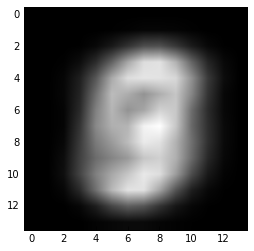

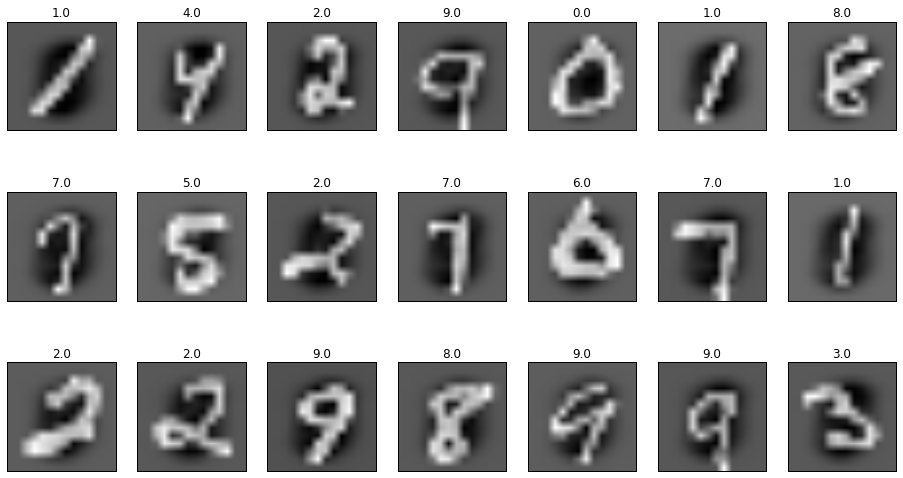

In [2]:
%reset -f
# Load necessary library modules
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

#import tensorflow as tf
import collections
np.random.seed(seed=8723)
# Two ways to load MNIST dataset
# Using sklean
# MNIST database contains a total of 70000 examples of handwritten digits of size 28*28 pixels, labeled 0 to 9
from sklearn.datasets.mldata import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home = None)

# # Using tensorflow
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Plot a gallery of images
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

h = 28     # height of the digit
w = 28     # width of the digit

data = np.vstack(mnist.data.data.obj).astype(float)
data = data.reshape((-1, h, w))
data = data[:,::2,::2]

h /=2
w /=2

data = data.reshape((-1, h*w))
labels = mnist.target
portion = 1.
N = int(portion*data.shape[0])
shuffle_idx = np.random.permutation(data.shape[0])[:N]
data = data[shuffle_idx]
# shuffle_idx = np.random.permutation(data.shape[0])[:N]
labels = labels[shuffle_idx]

# demean
ave_total = data.mean(axis=0)
data -= ave_total 


plt.imshow(ave_total.reshape(h,w),cmap=plt.cm.gray)
# Visualize the demeaned digits
plt_row = 3
plt_col = 7
data_view = []
titles_view = []
for i in range(plt_row*plt_col+1):
    data_view.append(data[i,:].reshape(h,w))
    titles_view.append(labels[i])

plot_gallery(data_view, titles_view, h, w, n_row=plt_row, n_col=plt_col)

# To see what BCM learning rule is really doing, we will compare it with using PCA, ICA on MNIST

# See the downloaded MNIST data
#a = np.where(labels == 3,1,0)
#collections.Counter(a)y
# Take a small portion of the dyataset

Compute the principle component of each group of digits. We need to sort the data_sm based on the label

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


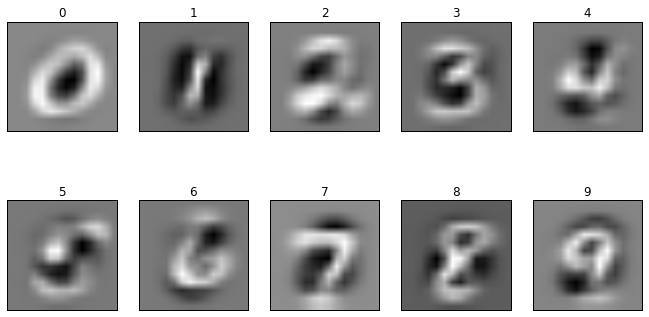

In [4]:
group_id = []
ave_digi = []
for i in range(10):
    group_id_tmp = labels == i
    group_id.append(group_id_tmp)
    ave_digi_tmp = data[group_id_tmp,:].mean(axis=0)
    ave_digi.append(ave_digi_tmp.reshape(h,w))
    
# plot the average image of each digit
plt_row = 2
plt_col = 5

titles_digi= range(10)

plot_gallery(ave_digi, titles_digi, h, w, n_row=plt_row, n_col=plt_col)

In [27]:
pca.components_.shape

(20, 196)

Extracting the top 20 eigendigits from 70000 faces
done in 0.785s


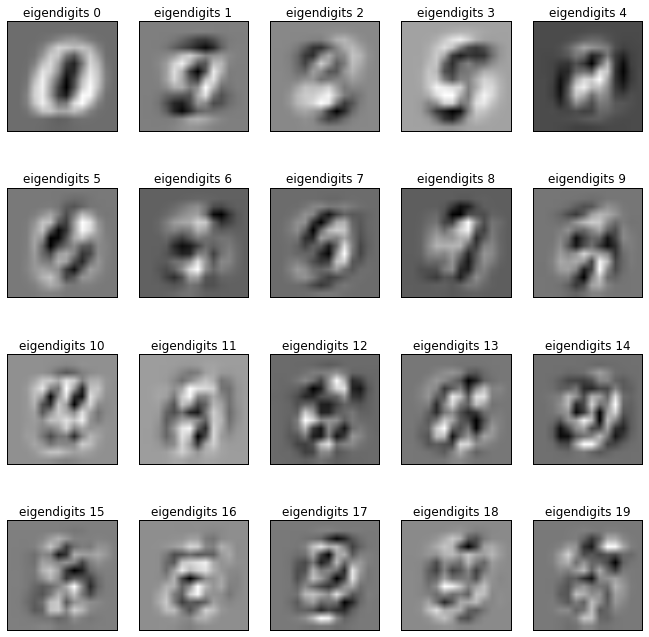

In [5]:
# PCA analysis
from time import time
from sklearn.decomposition import RandomizedPCA
from sklearn.cross_validation import train_test_split
# Split into training and testing dataset
data_train,data_test,labels_train, labels_test = train_test_split(data,labels,test_size = 0 , random_state = 8723)

# Compute the PCA (eigendigits) on the digits
n_components = 20

print("Extracting the top %d eigendigits from %d faces" % (n_components,data_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components = n_components, whiten = False).fit(data_train)
print("done in %0.3fs" % (time()-t0))

h = 14
w = 14
eigendigits = pca.components_.reshape((n_components,h,w))
eigendigits_titles = ["eigendigits %d" % i for i in range (pca.components_.shape[0])]
plot_gallery(eigendigits,eigendigits_titles,h,w,n_row= 4, n_col=5)


Extracting the top 20 icadigits from 70000 faces
done in 11.551s


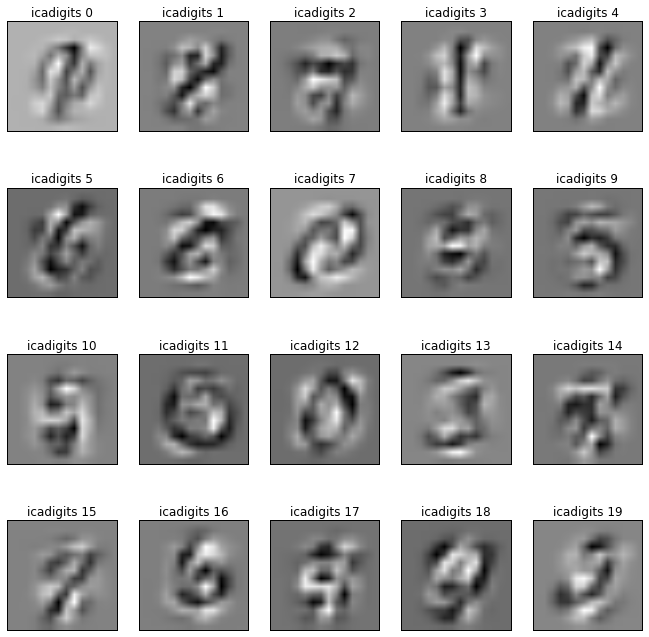

In [6]:
# Perform ICA analysis
from sklearn.decomposition import FastICA

# Split into training and testing dataset
data_train,data_test,labels_train, labels_test = train_test_split(data,labels,test_size = 0 , random_state = 8723)

# Compute the ICA (eigendigits) on the digits
n_components = 20

print("Extracting the top %d icadigits from %d faces" % (n_components,data_train.shape[0]))
t0 = time()
ica = FastICA(n_components = n_components, whiten = True).fit(data_train)
print("done in %0.3fs" % (time()-t0))

h = 14
w = 14
icadigits = ica.components_.reshape((n_components,h,w))
icadigits_titles = ["icadigits %d" % i for i in range (ica.components_.shape[0])]
plot_gallery(icadigits,icadigits_titles,h,w,n_row= 4, n_col=5)


done in 1.383s


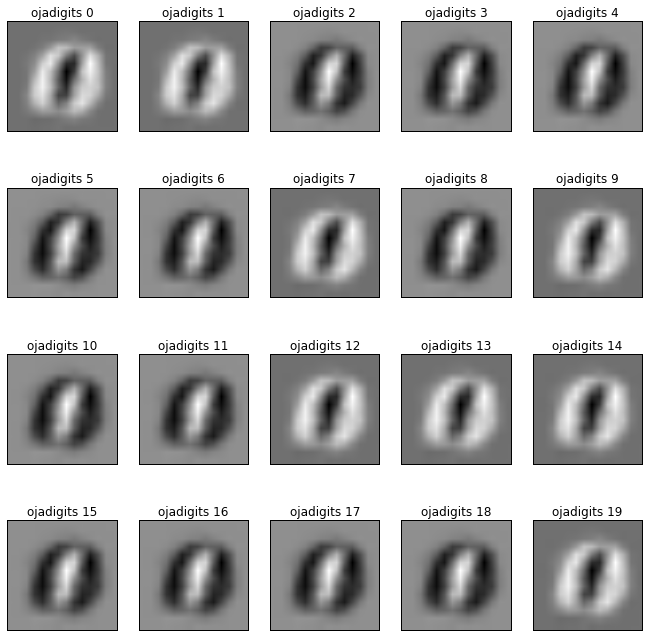

In [7]:
# Train Oja's rule with customized code
data_train,data_test,labels_train, labels_test = train_test_split(data,labels,test_size = 0 , random_state = 8723)

class Oja(object):
    """Oja learning
    Parameter:
    eta: float, learning rate (between 0.0 - 1.0)
    n_iter: int, passes over the training dataset
    ny: number of output neurons
    batchsize: float, percentage of data that are used to update the weight once
    
    Attributes:
    w_: 1d-array, weights after fitting
    error_: list, number of misclassification in every epoch
    """
    def __init__(self, eta = 0.1,n_iter = 10,ny = 1,batchsize = 100):
        self.eta = eta
        self.n_iter = n_iter
        self.ny = ny
        self.batchsize = batchsize
        
    def fit(self,X):
        """fitting training data
        Parameter:
        X: {array-like}, shape = [n_samples,n_features]
        Returns: self:object
        ny: value, number of output neurons
        """
        # Weights initialized as normal distribution
        self.w_ = np.random.randn(len(X[1,:]),self.ny)  # 196*20
        self.error_ = []
        
# # Use elementwise training      
#         for _ in range(self.n_iter):
#             for i in range(len(X[:,1])):   # 70000, elementwise training for all samples
#                 xi = X[i,:]           # 1*196
#                 y = np.dot(xi,self.w_)     # 1*20
#                 for j in range(len(y)):
#                     recons =  y[j]*self.w_[:,j] 
#                     err_tmp = xi[:,None] - recons[:,None]      # 196*1 
#                     update = self.eta * y[j]*err_tmp  # 196*20 
#                     self.w_[:,j][:,None]+= update   # Update weights
#         return self

# Learning rule goes here
# Use batch training
        for _ in range(self.n_iter):
            minibatch = round(len(X[:,1])/self.batchsize)
            for i in range(minibatch):   # 70000, elementwise training for all samples
                xi = X[i*self.batchsize:(i+1)*self.batchsize,:].mean(axis = 0)   # 1*196 Average batch before training 
                y = np.dot(xi,self.w_)     # 1*20
                for j in range(len(y)):
                    recons =  y[j]*self.w_[:,j] 
                    recons_err = xi[:,None] - recons[:,None]      # 196*1 
                    update = self.eta * y[j]*recons_err  # 196*20 
                    self.w_[:,j][:,None]+= update   # Update weights
        return self
    
ny = 20

# batchsize = 1, eta = 0.0000000005,n_iter = 100
# batchsize = 100, eta = 0.000005,n_inter = 1-
Oja_mnist = Oja(eta = 0.000005,n_iter = 10, ny = ny,batchsize = 100)

t0 = time()
Oja_mnist.fit(data_train)
print("done in %0.3fs" % (time()-t0))

h = 14
w = 14
ojadigits = []
for i in range(ny):
    ojadigits_tmp = Oja_mnist.w_[:,i];
    ojadigits.append(ojadigits_tmp.reshape(h,w))
    
ojadigits_titles = ["ojadigits %d" % i for i in range (ny)]
plot_gallery(ojadigits,ojadigits_titles,h,w,n_row= 4, n_col=5)

From the above Oja's rule implementation we could see the relationship among learning rate, batchsize and n_iter. When using elementwise implementation, we would like to have small learning rate to prevent blow up. With larger batch size, we could using bigger learning rate, or actually adapt the learing rate.

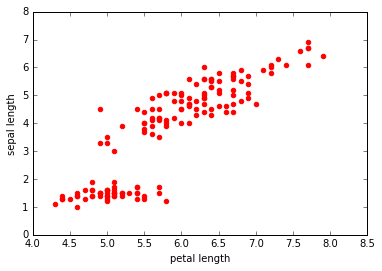

In [8]:
# Use the iris 2D data
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.tail()   # Visualize in the table last rows of the dataframe

y = df.iloc[:, 4].values  # pandas dataframe, select data by location index
y = np.where(y == 'Iris-setosa',1,-1)
X = df.iloc[:,[0,2]].values


# Shuffle the iris data preparing for training
shuffle_idx = np.random.permutation(len(X[:,1]))[:N]
X = X[shuffle_idx]    # 150*2
#X -= X.mean(axis = 0)
y = y[shuffle_idx]

plt.scatter(X[:,0],X[:,1],color = 'red',marker = 'o')
#plt.scatter(X[500:100,0],X[500:100,1],color = 'blue', marker = '*', label = 'versicolor')
plt.xlabel('petal length')
plt.ylabel('sepal length')



In [ ]:
# Check activity distribution with random initializtion of w
# np.random.seed(seed=8723)
w = np.random.randn(len(X.T)) # 2*100
# Generate output from data and one random initialization of weights
y = np.dot(X,w) # 150*2 , 2*1
y[y<0]=0

# the histogram of the output
n, bins, patches = plt.hist(y)

In [ ]:
# BCM class using convolution for exponential moving average
from scipy.ndimage.filters import convolve1d

class BCM_cov:
    """BCM learning
    Parameter:
    eta: float, learning rate (between 0.0 - 1.0)
    n_iter: int, passes over the training dataset
    ny: number of output neurons
    batchsize: float, percentage of data that are used to update the weight once
    
    Attributes:
    w_: 1d-array, weights after fitting
    error_: list, number of misclassification in every epoch
    """
    def __init__(self, eta = 0.1,n_iter = 10,ny = 1,tau = 10, batchsize = 10,thres = 0, p = 2,random_state = None, shuffle = True):
        self.eta = eta
        self.n_iter = n_iter
        self.ny = ny
        self.batchsize = batchsize
        self.tau = tau,   # Time constant for calculating thresholds
        self.thres = [thres*np.ones(ny)]
        self.p = p    # int, power for threshold computation
        self.y_thres = []      # Storaged y for studying effect of threshold
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
            
    def fit(self,X):
        """fitting training data
        Parameter:
        X: {array-like}, shape = [n_samples,n_features]
        Returns: self:object
        ny: value, number of output neurons
        """
        # Weights initialized as normal distribution
        self.w_ = np.random.randn(X.shape[1],self.ny) # 2*1
        self.w_track = [];
        # Use elementwise training 
        for _ in range(self.n_iter):
            if self.shuffle:
                X = self._shuffle(X)
            for i, xi in enumerate(X):   # 150, elementwise training for all samples
                threshold = self.thres[-1]
                y = np.dot(xi,self.w_)     # 1
                y[y < 0] = 0
                self.y_thres.append(y)
                y = np.atleast_2d(y)
                self.w_track.append(self.w_)
                self.w_ = self.w_+ self.eta * xi[:,None] * y * (y - threshold)
                y_power = np.vstack(self.y_thres).T ** self.p    
                n = y_power.shape[1]
                t = np.arange(n)
                h = np.exp(-t/self.tau)
                theta = np.vstack([np.convolve(yp, h, mode='full')[:n] for yp in y_power])/self.tau
                self.thres.append(theta[:,-1])
        return self

    def _shuffle(self,X):
            r = np.random.permutation(len(X))
            return X[r]



In [3]:
# Train BCM model with Iris data, (sample size might be too small)
from sklearn.cross_validation import train_test_split

data_train,data_test,labels_train, labels_test = train_test_split(X,y,test_size = 0 , random_state = 8723)

ny = 2
n_iter = 20
p = 2
eta = 0.00001
tau = 200
BCM_iris = BCM(eta = eta,n_iter = n_iter,ny = 2,tau = 200, batchsize = 0,thres = 0, p = p)

#print("Training with Oja's rule from %d digits" % (n_components,data_train.shape[0]))
t0 = time()
BCM_iris.fit(data_train)
print("done in %0.3fs" % (time()-t0))

#x_plot = range(n_iter * len(X))
plt_range = n_iter * len(X)
BCM_iris_thres = np.vstack(BCM_iris.thres)
BCM_iris_out = np.vstack(BCM_iris.y_thres)
#BCM_iris_w = np.vstack(BCM_iris.w_track)

n_row = 1
n_column = ny

BCMiris_titles= ["BCM outputs %d" % i for i in range (ny)]
# Plot y and threshold
for i in range(ny):
    plt.subplot(n_row,n_column,i+1)
    plt.plot(BCM_iris_out[:plt_range,i],'g-',label = 'output')
    plt.plot(BCM_iris_thres[:plt_range,i],'r--',label = 'threshold')
    plt.title(BCMiris_titles[i])

plt.legend(loc = 'upper right')

plt.figure()
# Plot weights
BCMiris_title_w = ["BCM weights %d" % i for i in range (ny)]

for i in range(ny):
    plt.subplot(n_row,n_column,i+1)
    for j in range(0,plt_range,20):
        plt.plot(BCM_iris.w_track[j][0,i],BCM_iris.w_track[j][1,i],'ro',label = 'weight')
        plt.plot(BCM_iris.w_track[0][0,i],BCM_iris.w_track[0][1,i],'go',label = 'weight')
        plt.plot(BCM_iris.w_track[plt_range-1][0,i],BCM_iris.w_track[plt_range-1][1,i],'yo',label = 'weight')
    plt.title(BCMiris_title_w[i])


NameError: name 'X' is not defined

In [ ]:
# Train BCM model with MINIST data
data_train,data_test,labels_train, labels_test = train_test_split(data,labels,test_size = 0 , random_state = 8723)

ny = 2
n_iter = 20
p = 2
eta = 0.00001
tau = 200
BCM_iris = BCM(eta = eta,n_iter = n_iter,ny = 2,tau = 200, batchsize = 0,thres = 0, p = p)

#print("Training with Oja's rule from %d digits" % (n_components,data_train.shape[0]))
t0 = time()
BCM_iris.fit(data_train)
print("done in %0.3fs" % (time()-t0))


n_row = 1
n_col = ny

ojadigits_titles = ["BCM outputs %d" % i for i in range (ny)]
h = 14
w = 14
ojadigits = []
for i in range(ny):
    ojadigits_tmp = Oja_mnist.w_[:,i];
    ojadigits.append(ojadigits_tmp.reshape(h,w))
    
ojadigits_titles = ["ojadigits %d" % i for i in range (ny)]
plot_gallery(ojadigits,ojadigits_titles,h,w,n_row= n_row, n_col= n_col )


In [267]:
i

0

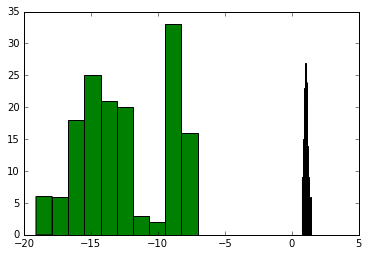

In [194]:
y2 = np.dot(X,BCM_iris.w_[:,0])
n, bins, patches = plt.hist(y2)
y3 = np.dot(X,BCM_iris.w_[:,1])
n, bins, patches = plt.hist(y3)

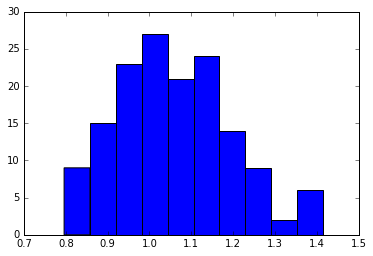

In [190]:
hist(y2)